# ML from image-based data (cells – compound experiment)
Predict drug dosage learning on cell morphological features extracted by image segmentation from microscopy data (tumor MCF7 cells under podophyllotoxin treatment).

Data contains multi-parametric measuremnts for two independent channels: **n** channel for DAPI (shows DNA staining in the cell nucleus) and **a** channel for actin (shows the cell boundary).

Image source: Broad Bioimage Benchmark Collection https://bbbc.broadinstitute.org/BBBC021

Image segmentation: Pretrained DL-based model CellPose http://www.cellpose.org

Morphological measurement: ImageJ https://imagej.net/ij/


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as plticker
from matplotlib import ticker
import random
import scipy.stats

#### Load data

In [3]:
df=pd.read_csv('podophyllotoxin.csv')
df.dropna()

,Number,NumberInFile,Area,Mean,StdDev,Min,Max,X,Y,XM,...,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,ImageNumber,Concentration,Channel
0,1,1,847,3732.231,489.151,2272,4848,177.488,12.584,177.628,...,162,21,30.466,28.000,1.252,0.799,0.985,2673,0.000003,n
1,2,2,403,2493.499,292.540,1520,3184,374.393,6.649,374.782,...,358,2,3.366,16.000,1.967,0.508,0.977,2673,0.000003,n
2,3,3,138,7880.812,2903.436,2768,13472,449.290,3.819,449.347,...,438,1,168.690,9.000,2.145,0.466,0.965,2673,0.000003,n
3,4,4,237,3779.511,468.389,2096,4576,534.116,4.580,533.934,...,519,0,178.025,11.000,2.393,0.418,0.983,2673,0.000003,n
4,5,5,968,3434.380,517.929,1824,4464,657.557,14.174,658.166,...,638,9,165.256,31.000,1.244,0.804,0.984,2673,0.000003,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,3165,88,634,8086.814,2454.631,2816,14832,1264.366,1012.849,1266.237,...,1246,1023,38.234,23.484,1.747,0.572,0.962,2648,0.010000,a
3165,3166,89,9694,3375.941,989.556,752,9008,179.923,183.907,183.526,...,83,182,12.330,135.348,1.349,0.741,0.619,2648,0.010000,a
3166,3167,90,1733,4140.602,1016.060,1744,7280,1011.293,829.720,1015.006,...,971,844,12.407,27.455,4.473,0.224,0.848,2648,0.010000,a
3167,3168,91,4232,7173.013,3062.623,3488,15472,146.150,822.737,152.478,...,104,840,12.600,67.000,1.283,0.779,0.934,2648,0.010000,a


Split into nucleus and cell dataframes

In [4]:
df_n = df[df.Channel == 'n'].copy()
df_a = df[df.Channel == 'a'].copy()

#### Data distibution

In [5]:
sns.set_theme(rc={'figure.figsize':(6,3)})

Text(0.5, 1.0, 'Nucleus')

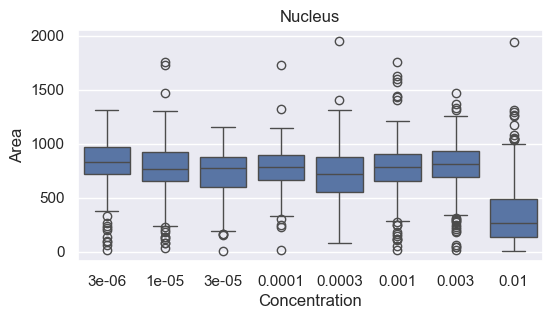

In [6]:
sns.boxplot(data=df_n, x="Concentration", y="Area").set_title('Nucleus')

Text(0.5, 1.0, 'Nucleus')

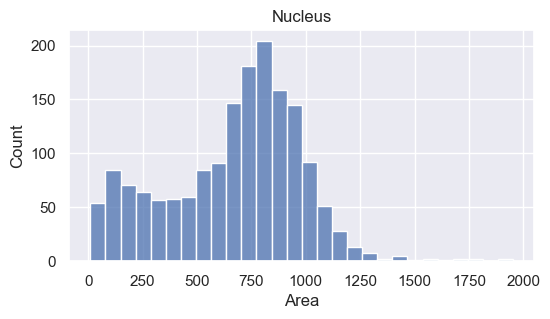

In [7]:
sns.histplot(data=df_n, x="Area").set_title('Nucleus')

<Axes: xlabel='Area', ylabel='Count'>

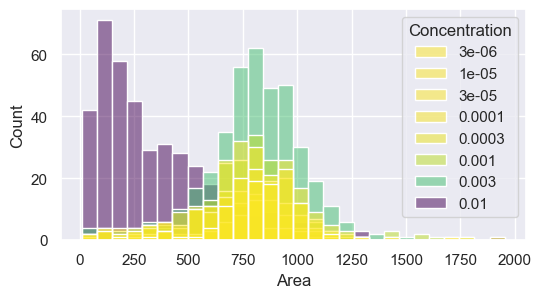

In [8]:
sns.histplot(data=df_n, x="Area", hue='Concentration', palette="viridis_r")

Text(0.5, 1.0, 'Cell')

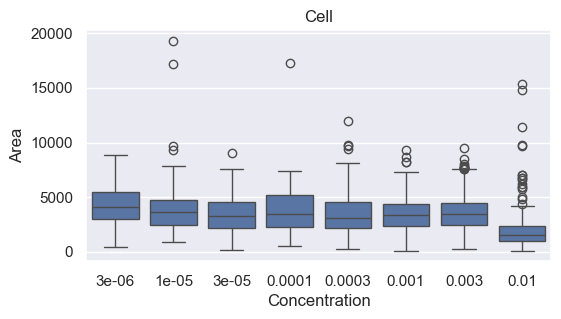

In [9]:
sns.boxplot(data=df_a, x="Concentration", y="Area").set_title('Cell')

Text(0.5, 1.0, 'Cell')

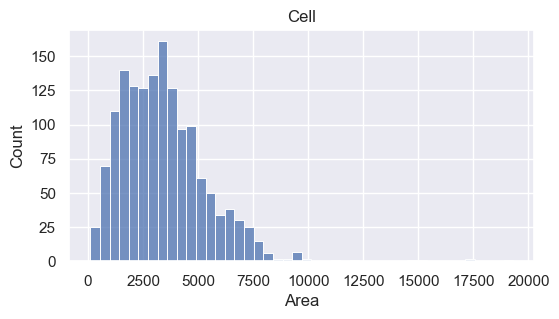

In [10]:
sns.histplot(data=df_a, x="Area").set_title('Cell')

<Axes: xlabel='Area', ylabel='Count'>

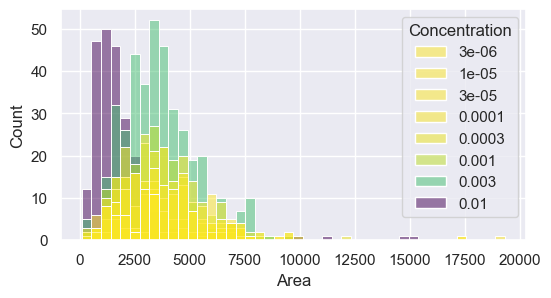

In [11]:
sns.histplot(data=df_a, x="Area", hue='Concentration', palette="viridis_r")

## Model using only nuclei data

#### T-test, ANOVA

In [12]:
grouped = df_n.groupby('Concentration')
grouped.size()

Concentration
0.000003    137
0.000010    211
0.000030    144
0.000100     56
0.000300    120
0.001000    206
0.003000    392
0.010000    404
dtype: int64

In [13]:
# split into groups and do ANOVA test
group_data = [group['Area'] for name, group in grouped]

f_statistic, p_value = scipy.stats.f_oneway(*group_data)
print("p-value:", p_value)

p-value: 1.0414346094219527e-149


In [14]:
# p-values for group pairs
p_values = []

group_names = grouped.groups.keys()
group_names_sorted = sorted(group_names)  
for i in range(len(group_names_sorted) - 1):
    group1 = grouped.get_group(group_names_sorted[i])['Area']
    group2 = grouped.get_group(group_names_sorted[i + 1])['Area']
    
    # t-test
    t_statistic, p_value = scipy.stats.ttest_ind(group1, group2)
    p_values.append(p_value)

print("P-values between groups:")
for i, p_value in enumerate(p_values):
    group1 = group_names_sorted[i]
    group2 = group_names_sorted[i + 1]
    print(f" {group1} and {group2}: {p_value}")

P-values between groups:
 3e-06 and 1e-05: 0.12099941018490049
 1e-05 and 3e-05: 0.16905481956995744
 3e-05 and 0.0001: 0.13053510653438163
 0.0001 and 0.0003: 0.12714460558117796
 0.0003 and 0.001: 0.07051486583666002
 0.001 and 0.003: 0.11964553996991323
 0.003 and 0.01: 1.5455051266822603e-106


### Feature selection

In [16]:
df_n.shape

(1670, 38)

##### Correlation

/var/folders/j9/1tmlv58j1xd3lt3y_0kmwl4r0000gn/T/ipykernel_15485/3975639476.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_n.corr()


<Axes: >

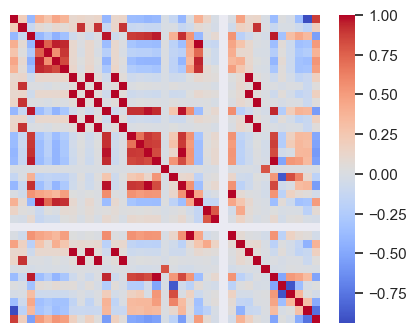

In [17]:
cor = df_n.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(cor, xticklabels=False, yticklabels=False, cmap= 'coolwarm')

In [18]:
cor.style.background_gradient(cmap='coolwarm')

/Users/andrei/anaconda3/lib/python3.10/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/andrei/anaconda3/lib/python3.10/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Number,NumberInFile,Area,Mean,StdDev,Min,Max,X,Y,XM,YM,Perim.,BX,BY,Width,Height,Major,Minor,Angle,Circ.,Feret,IntDen,Median,Skew,Kurt,%Area,RawIntDen,Ch,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,ImageNumber,Concentration
Number,1.000000,0.210836,-0.398575,0.402571,0.276289,0.450264,0.377353,0.111455,0.133853,0.111463,0.133809,-0.408933,0.115523,0.139485,-0.363898,-0.375288,-0.415637,-0.389417,-0.015257,-0.133737,-0.406221,-0.007010,0.393155,0.146017,-0.015464,nan,-0.007010,0.471711,0.114174,0.133553,-0.012080,-0.378423,0.016386,-0.030165,-0.358670,-0.939291,0.878646
NumberInFile,0.210836,1.000000,-0.118304,0.079162,0.037635,0.104259,0.068822,0.121805,0.905217,0.121759,0.905217,-0.127056,0.123077,0.907022,-0.118298,-0.105653,-0.122217,-0.121542,-0.010161,-0.005888,-0.125222,-0.069178,0.079515,0.043229,-0.032376,nan,-0.069178,0.171142,0.122820,0.904452,0.003864,-0.117779,-0.010399,-0.013991,-0.082325,-0.185930,0.189803
Area,-0.398575,-0.118304,1.000000,-0.397492,-0.259355,-0.444739,-0.335133,-0.071662,0.010390,-0.071579,0.010420,0.968423,-0.081552,-0.003185,0.879888,0.899292,0.915752,0.956329,-0.004132,0.390903,0.916000,0.543923,-0.395921,0.012122,0.091289,nan,0.543923,-0.199205,-0.077756,0.011424,-0.030335,0.957544,-0.330716,0.313263,0.439791,0.347195,-0.544299
Mean,0.402571,0.079162,-0.397492,1.000000,0.757536,0.947257,0.937816,0.107873,0.009625,0.107919,0.009548,-0.366212,0.111317,0.014905,-0.309205,-0.357496,-0.362444,-0.371961,0.017488,-0.183906,-0.353542,0.456328,0.996550,-0.100185,-0.123964,nan,0.456328,0.276523,0.109244,0.009795,-0.009989,-0.360124,0.066473,-0.087509,-0.341674,-0.316233,0.511586
StdDev,0.276289,0.037635,-0.259355,0.757536,1.000000,0.562406,0.898082,0.106679,-0.010624,0.106745,-0.010661,-0.218191,0.108780,-0.007562,-0.187760,-0.209233,-0.211124,-0.243411,0.001914,-0.152414,-0.201757,0.411536,0.725818,0.027620,-0.074594,nan,0.411536,0.113398,0.107572,-0.011184,-0.016352,-0.230397,0.039953,-0.083086,-0.281961,-0.240188,0.384278
Min,0.450264,0.104259,-0.444739,0.947257,0.562406,1.000000,0.837701,0.105604,0.024589,0.105625,0.024507,-0.424496,0.109607,0.030741,-0.360339,-0.412519,-0.418906,-0.417906,0.013486,-0.178401,-0.412771,0.352657,0.944508,-0.002026,-0.068655,nan,0.352657,0.408525,0.107330,0.024985,-0.005053,-0.409066,0.080028,-0.089215,-0.331016,-0.356571,0.536542
Max,0.377353,0.068822,-0.335133,0.937816,0.898082,0.837701,1.000000,0.127361,0.003919,0.127433,0.003866,-0.290926,0.130076,0.008130,-0.245340,-0.284953,-0.284116,-0.311692,-0.000992,-0.176553,-0.274516,0.488277,0.915580,0.086157,0.025444,nan,0.488277,0.263625,0.128327,0.003819,-0.018997,-0.297518,0.052483,-0.090730,-0.329840,-0.317720,0.485522
X,0.111455,0.121805,-0.071662,0.107873,0.106679,0.105604,0.127361,1.000000,0.057792,0.999999,0.057730,-0.075492,0.999935,0.058701,-0.078511,-0.059991,-0.072401,-0.084463,-0.008458,-0.076863,-0.075133,0.025896,0.101049,0.072465,0.052853,nan,0.025896,0.090470,0.999881,0.057112,0.007185,-0.079100,0.055707,-0.042236,-0.156453,-0.112706,0.174614
Y,0.133853,0.905217,0.010390,0.009625,-0.010624,0.024589,0.003919,0.057792,1.000000,0.057777,0.999998,0.012689,0.057756,0.999884,0.005326,0.022977,0.015289,0.008644,-0.004471,0.030498,0.011478,0.004281,0.011166,0.019644,-0.020837,nan,0.004281,0.104841,0.057963,0.999096,0.011473,0.010970,-0.026507,0.009103,0.002848,-0.105826,0.041121
XM,0.111463,0.121759,-0.071579,0.107919,0.106745,0.105625,0.127433,0.999999,0.057777,1.000000,0.057715,-0.075403,0.999933,0.058686,-0.078435,-0.059924,-0.072313,-0.084389,-0.008553,-0.076862,-0.075046,0.026023,0.101093,0.072427,0.052853,nan,0.026023,0.090424,0.999880,0.057098,0.007149,-0.079023,0.055710,-0.042229,-0.156423,-0.112718,0.174626


In [19]:
df_n_copy = df_n.copy()
df_n_copy.shape

(1670, 38)

In [20]:
df_n_copy.dtypes

Number             int64
NumberInFile       int64
Area               int64
Mean             float64
StdDev           float64
Min                int64
Max                int64
X                float64
Y                float64
XM               float64
YM               float64
Perim.           float64
BX                 int64
BY                 int64
Width              int64
Height             int64
Major            float64
Minor            float64
Angle            float64
Circ.            float64
Feret            float64
IntDen             int64
Median             int64
Skew             float64
Kurt             float64
%Area              int64
RawIntDen          int64
Ch                 int64
FeretX             int64
FeretY             int64
FeretAngle       float64
MinFeret         float64
AR               float64
Round            float64
Solidity         float64
ImageNumber        int64
Concentration    float64
Channel           object
dtype: object

In [21]:
columns = ['Number','NumberInFile', '%Area','ImageNumber','Channel']
df_n_copy.drop(columns, axis=1, inplace=True)
df_n_copy.shape

(1670, 33)

In [22]:
cor = df_n_copy.corr()
cor.style.background_gradient(cmap='coolwarm')

,Area,Mean,StdDev,Min,Max,X,Y,XM,YM,Perim.,BX,BY,Width,Height,Major,Minor,Angle,Circ.,Feret,IntDen,Median,Skew,Kurt,RawIntDen,Ch,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,Concentration
Area,1.000000,-0.397492,-0.259355,-0.444739,-0.335133,-0.071662,0.010390,-0.071579,0.010420,0.968423,-0.081552,-0.003185,0.879888,0.899292,0.915752,0.956329,-0.004132,0.390903,0.916000,0.543923,-0.395921,0.012122,0.091289,0.543923,-0.199205,-0.077756,0.011424,-0.030335,0.957544,-0.330716,0.313263,0.439791,-0.544299
Mean,-0.397492,1.000000,0.757536,0.947257,0.937816,0.107873,0.009625,0.107919,0.009548,-0.366212,0.111317,0.014905,-0.309205,-0.357496,-0.362444,-0.371961,0.017488,-0.183906,-0.353542,0.456328,0.996550,-0.100185,-0.123964,0.456328,0.276523,0.109244,0.009795,-0.009989,-0.360124,0.066473,-0.087509,-0.341674,0.511586
StdDev,-0.259355,0.757536,1.000000,0.562406,0.898082,0.106679,-0.010624,0.106745,-0.010661,-0.218191,0.108780,-0.007562,-0.187760,-0.209233,-0.211124,-0.243411,0.001914,-0.152414,-0.201757,0.411536,0.725818,0.027620,-0.074594,0.411536,0.113398,0.107572,-0.011184,-0.016352,-0.230397,0.039953,-0.083086,-0.281961,0.384278
Min,-0.444739,0.947257,0.562406,1.000000,0.837701,0.105604,0.024589,0.105625,0.024507,-0.424496,0.109607,0.030741,-0.360339,-0.412519,-0.418906,-0.417906,0.013486,-0.178401,-0.412771,0.352657,0.944508,-0.002026,-0.068655,0.352657,0.408525,0.107330,0.024985,-0.005053,-0.409066,0.080028,-0.089215,-0.331016,0.536542
Max,-0.335133,0.937816,0.898082,0.837701,1.000000,0.127361,0.003919,0.127433,0.003866,-0.290926,0.130076,0.008130,-0.245340,-0.284953,-0.284116,-0.311692,-0.000992,-0.176553,-0.274516,0.488277,0.915580,0.086157,0.025444,0.488277,0.263625,0.128327,0.003819,-0.018997,-0.297518,0.052483,-0.090730,-0.329840,0.485522
X,-0.071662,0.107873,0.106679,0.105604,0.127361,1.000000,0.057792,0.999999,0.057730,-0.075492,0.999935,0.058701,-0.078511,-0.059991,-0.072401,-0.084463,-0.008458,-0.076863,-0.075133,0.025896,0.101049,0.072465,0.052853,0.025896,0.090470,0.999881,0.057112,0.007185,-0.079100,0.055707,-0.042236,-0.156453,0.174614
Y,0.010390,0.009625,-0.010624,0.024589,0.003919,0.057792,1.000000,0.057777,0.999998,0.012689,0.057756,0.999884,0.005326,0.022977,0.015289,0.008644,-0.004471,0.030498,0.011478,0.004281,0.011166,0.019644,-0.020837,0.004281,0.104841,0.057963,0.999096,0.011473,0.010970,-0.026507,0.009103,0.002848,0.041121
XM,-0.071579,0.107919,0.106745,0.105625,0.127433,0.999999,0.057777,1.000000,0.057715,-0.075403,0.999933,0.058686,-0.078435,-0.059924,-0.072313,-0.084389,-0.008553,-0.076862,-0.075046,0.026023,0.101093,0.072427,0.052853,0.026023,0.090424,0.999880,0.057098,0.007149,-0.079023,0.055710,-0.042229,-0.156423,0.174626
YM,0.010420,0.009548,-0.010661,0.024507,0.003866,0.057730,0.999998,0.057715,1.000000,0.012722,0.057694,0.999882,0.005331,0.023033,0.015316,0.008678,-0.004430,0.030525,0.011508,0.004220,0.011092,0.019646,-0.020798,0.004220,0.104767,0.057902,0.999096,0.011494,0.011010,-0.026540,0.009115,0.002862,0.041104
Perim.,0.968423,-0.366212,-0.218191,-0.424496,-0.290926,-0.075492,0.012689,-0.075403,0.012722,1.000000,-0.085768,-0.001122,0.914558,0.914326,0.970608,0.929852,-0.002240,0.260836,0.975311,0.574765,-0.366099,0.033316,0.105660,0.574765,-0.193034,-0.082237,0.013778,-0.034304,0.936092,-0.237370,0.200470,0.378895,-0.561337


#### Drop mutually correlated features 

In [23]:
all_features = list(cor.columns)
f_to_del = []

for i in cor.columns:
    if i =='Concentration':
        continue
    for j in cor.index:
        if all_features.index(j) >= all_features.index(i) or j =='Concentration' :
            continue
        else:
            if abs(cor.loc[i, j]) > 0.8: 
                if abs(cor.loc['Concentration', i]) > abs(cor.loc['Concentration', j]):
                    f_to_del.append(j)
                else:
                    f_to_del.append(i)

In [24]:
f_to_del = set(f_to_del)
f_to_del

{'AR',
 'Area',
 'Feret',
 'FeretAngle',
 'FeretX',
 'FeretY',
 'Height',
 'Max',
 'Mean',
 'Median',
 'MinFeret',
 'Minor',
 'Perim.',
 'RawIntDen',
 'Round',
 'StdDev',
 'Width',
 'X',
 'XM',
 'Y',
 'YM'}

In [25]:
for i in f_to_del:
    del df_n_copy[i]

In [26]:
df_n_copy.shape

(1670, 12)

In [27]:
cor = df_n_copy.corr()
cor.style.background_gradient(cmap='coolwarm')

,Min,BX,BY,Major,Angle,Circ.,IntDen,Skew,Kurt,Ch,Solidity,Concentration
Min,1.000000,0.109607,0.030741,-0.418906,0.013486,-0.178401,0.352657,-0.002026,-0.068655,0.408525,-0.331016,0.536542
BX,0.109607,1.000000,0.058782,-0.082424,-0.008533,-0.079500,0.019725,0.071985,0.051648,0.092174,-0.160007,0.180114
BY,0.030741,0.058782,1.000000,0.001965,-0.004135,0.026206,-0.003495,0.019349,-0.022104,0.107771,-0.002288,0.048989
Major,-0.418906,-0.082424,0.001965,1.000000,-0.008909,0.127328,0.537627,0.039421,0.103007,-0.184575,0.349777,-0.571289
Angle,0.013486,-0.008533,-0.004135,-0.008909,1.000000,-0.003250,-0.011010,-0.021595,-0.002605,-0.011611,0.013911,-0.017413
Circ.,-0.178401,-0.079500,0.026206,0.127328,-0.003250,1.000000,0.123447,0.009987,0.044741,-0.060656,0.609096,-0.182793
IntDen,0.352657,0.019725,-0.003495,0.537627,-0.011010,0.123447,1.000000,-0.051744,-0.002835,0.077115,0.080389,-0.052519
Skew,-0.002026,0.071985,0.019349,0.039421,-0.021595,0.009987,-0.051744,1.000000,0.785071,0.435779,-0.011072,0.080539
Kurt,-0.068655,0.051648,-0.022104,0.103007,-0.002605,0.044741,-0.002835,0.785071,1.000000,0.157650,0.046581,-0.033725
Ch,0.408525,0.092174,0.107771,-0.184575,-0.011611,-0.060656,0.077115,0.435779,0.157650,1.000000,-0.139305,0.383482


### Split into train/test

In [28]:
from sklearn.model_selection import train_test_split

X = df_n_copy.drop('Concentration', axis=1)
y = df_n_copy['Concentration']              

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [29]:
print(f'Train:{X_train.shape} Test:{X_test.shape}')

Train:(1336, 11) Test:(334, 11)


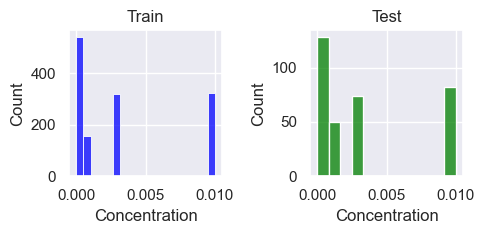

In [30]:
# Check if training/testing datasets are balanced 

fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))

sns.histplot(y_train, color='blue', ax=axes[0])
axes[0].set_title('Train')

sns.histplot(y_test, color='green', ax=axes[1])
axes[1].set_title('Test')

plt.tight_layout()

plt.show()

In [31]:
X_train.dtypes

Min           int64
BX            int64
BY            int64
Major       float64
Angle       float64
Circ.       float64
IntDen        int64
Skew        float64
Kurt        float64
Ch            int64
Solidity    float64
dtype: object

### Models

In [69]:
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



##### KNN

In [80]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsRegressor(n_neighbors=20, weights='distance'))
])

y_pred = pipe.fit(X_train, y_train).predict(X_test)

In [79]:
r2 = r2_score(y_test, y_pred)
print("R-squared (R²):", r2)

R-squared (R²): 0.6250275980728685


##### XGBOOST

In [68]:
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared (R²):", r2)

Mean Squared Error: 5.277504217259834e-06
R-squared (R²): 0.6667878042077957


In [60]:
y_pred.min()

-0.0007195416

In [40]:
err1=100*abs(y_pred-y_test)/y_test


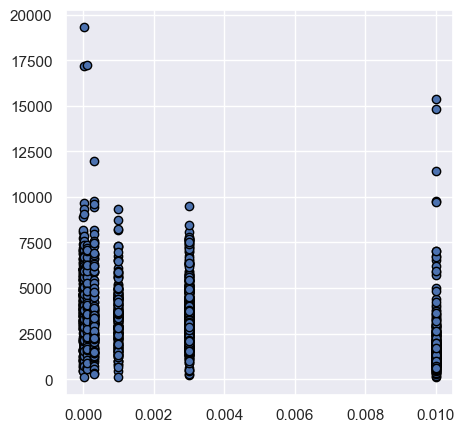

In [48]:
fig = plt.figure(figsize=(5,5))
plt.scatter(df_a['Concentration'],df_a['Area'], edgecolors=(0, 0, 0))
plt.show()

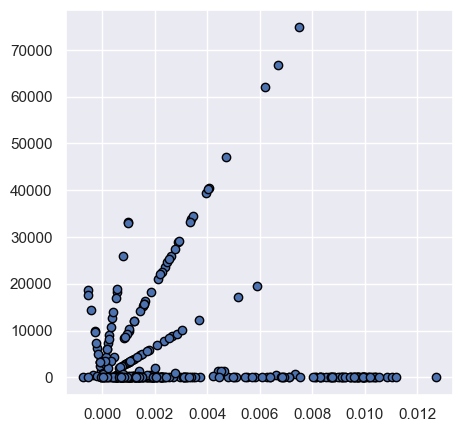

In [53]:
fig = plt.figure(figsize=(5,5))
plt.scatter(y_pred,err1, edgecolors=(0, 0, 0))
#plt.xlim(0.00001, 0.01)
#plt.ylim(0, 200)
plt.show()

In [372]:
# results without dropping correlated features
Mean Squared Error: 5.216429067766477e-06
R-squared (R²): 0.670643980126038

SyntaxError: invalid character '²' (U+00B2) (1912804268.py, line 3)

## Model using the entire dataset (cells+nuclei)

##### Feature preparation  

In [373]:
df_copy = df.copy()
df_copy.shape

(3169, 38)

In [374]:
# drop irrelevant culumns
columns = ['Number','NumberInFile', '%Area','ImageNumber']
df_copy.drop(columns, axis=1, inplace=True)
df_copy.shape

(3169, 34)

In [375]:
#replace categorical data
df_copy = pd.get_dummies(df_copy, drop_first=True)


In [376]:
df_copy.shape

(3169, 34)

In [377]:
df_copy_n

,Area,Mean,StdDev,Min,Max,X,Y,XM,YM,Perim.,...,Ch,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,Concentration,Channel_n
0,847,3732.231,489.151,2272,4848,177.488,12.584,177.628,12.134,109.358,...,1,162,21,30.466,28.000,1.252,0.799,0.985,0.000003,1
1,403,2493.499,292.540,1520,3184,374.393,6.649,374.782,6.397,83.599,...,1,358,2,3.366,16.000,1.967,0.508,0.977,0.000003,1
2,138,7880.812,2903.436,2768,13472,449.290,3.819,449.347,3.615,48.929,...,1,438,1,168.690,9.000,2.145,0.466,0.965,0.000003,1
3,237,3779.511,468.389,2096,4576,534.116,4.580,533.934,4.571,67.186,...,1,519,0,178.025,11.000,2.393,0.418,0.983,0.000003,1
4,968,3434.380,517.929,1824,4464,657.557,14.174,658.166,14.174,113.798,...,1,638,9,165.256,31.000,1.244,0.804,0.984,0.000003,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,634,8086.814,2454.631,2816,14832,1264.366,1012.849,1266.237,1011.368,103.887,...,3,1246,1023,38.234,23.484,1.747,0.572,0.962,0.010000,0
3165,9694,3375.941,989.556,752,9008,179.923,183.907,183.526,185.148,565.269,...,3,83,182,12.330,135.348,1.349,0.741,0.619,0.010000,0
3166,1733,4140.602,1016.060,1744,7280,1011.293,829.720,1015.006,829.260,235.534,...,3,971,844,12.407,27.455,4.473,0.224,0.848,0.010000,0
3167,4232,7173.013,3062.623,3488,15472,146.150,822.737,152.478,821.725,253.189,...,3,104,840,12.600,67.000,1.283,0.779,0.934,0.010000,0


In [378]:
cor = df_copy.corr()

In [379]:
all_features = list(cor.columns)
f_to_del = []

for i in cor.columns:
    if i =='Concentration':
        continue
    for j in cor.index:
        if all_features.index(j) >= all_features.index(i) or j =='Concentration' :
            continue
        else:
            if abs(cor.loc[i, j]) > 0.8: 
                if abs(cor.loc['Concentration', i]) > abs(cor.loc['Concentration', j]):
                    f_to_del.append(j)
                else:
                    f_to_del.append(i)

In [380]:
f_to_del = set(f_to_del)
f_to_del

{'AR',
 'Area',
 'Channel_n',
 'Feret',
 'FeretX',
 'FeretY',
 'Height',
 'IntDen',
 'Major',
 'Max',
 'Median',
 'MinFeret',
 'Perim.',
 'RawIntDen',
 'Solidity',
 'StdDev',
 'Width',
 'X',
 'XM',
 'Y',
 'YM'}

In [381]:
for i in f_to_del:
    del df_copy[i]

In [382]:
df_copy.shape

(3169, 13)

In [383]:
cor = df_copy.corr()
cor.style.background_gradient(cmap='coolwarm')

,Mean,Min,BX,BY,Minor,Angle,Circ.,Skew,Kurt,Ch,FeretAngle,Round,Concentration
Mean,1.000000,0.782423,0.123233,0.030559,-0.292920,-0.000150,0.092044,-0.177567,-0.133368,0.418667,-0.011186,0.066661,0.553055
Min,0.782423,1.000000,0.101175,0.058393,-0.563432,0.006605,0.377506,0.000475,-0.126989,0.367519,-0.004105,0.183218,0.495922
BX,0.123233,0.101175,1.000000,0.060287,-0.083015,-0.013566,-0.009686,0.057283,0.040182,0.088492,-0.009004,-0.023965,0.181328
BY,0.030559,0.058393,0.060287,1.000000,-0.047920,-0.009029,0.030777,-0.037616,-0.037012,0.112847,0.006398,-0.003234,0.060121
Minor,-0.292920,-0.563432,-0.083015,-0.047920,1.000000,-0.001053,-0.405029,0.032577,0.170040,-0.116398,0.005325,0.031983,-0.303027
Angle,-0.000150,0.006605,-0.013566,-0.009029,-0.001053,1.000000,0.010834,-0.008963,-0.015284,-0.005714,0.736190,0.015324,-0.017721
Circ.,0.092044,0.377506,-0.009686,0.030777,-0.405029,0.010834,1.000000,0.019635,-0.114294,0.014039,0.013211,0.725978,0.063021
Skew,-0.177567,0.000475,0.057283,-0.037616,0.032577,-0.008963,0.019635,1.000000,0.651750,0.005029,0.010363,0.011781,0.017929
Kurt,-0.133368,-0.126989,0.040182,-0.037012,0.170040,-0.015284,-0.114294,0.651750,1.000000,0.096587,0.009470,-0.047227,-0.027014
Ch,0.418667,0.367519,0.088492,0.112847,-0.116398,-0.005714,0.014039,0.005029,0.096587,1.000000,-0.014376,0.002090,0.371569


In [384]:
X = df_copy.drop('Concentration', axis=1)
y = df_copy['Concentration']              

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [385]:
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared (R²):", r2)

Mean Squared Error: 6.471773887834316e-06
R-squared (R²): 0.5663404783228038
